In [2]:
import matplotlib.image as img
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# from tensorflow.python.framework import ops
import math
import os
import keras
from keras import layers
from keras.layers import Dropout,Input, Cropping2D,merge,Add, Dense, Activation, ZeroPadding2D, SeparableConv2D,BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,Lambda,Convolution2D,Conv2DTranspose,UpSampling2D,Subtract,regularizers
from keras.models import Model, load_model,Sequential
from keras.layers.merge import concatenate
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.optimizers import SGD
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
import scipy.misc
import h5py
import matplotlib.image as img
from keras.callbacks import ModelCheckpoint,CSVLogger, LearningRateScheduler,ReduceLROnPlateau
from keras.optimizers import Adam
import cv2, datetime,sys,glob
#os.environ['KERAS_BACKEND']= 'theano'
import keras.backend as K
from keras.utils import multi_gpu_model
use_gpu_num = 3
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
#use cpu only
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
def read_points(file_name=None):
    """
    Read points from .pts file.
    """
    points = []
    with open(file_name) as file:
        line_count = 0
        for line in file:
            if "version" in line or "points" in line or "{" in line or "}" in line:
                continue
            else:
                loc_x, loc_y = line.strip().split(" ")
                points.append([float(loc_x), float(loc_y)])
                line_count += 1
    return points
def draw_landmark_point(image, points):
    """
    Draw landmark point on image.
    """
    for point in points:
        cv2.circle(image, (int(point[0]), int(
            point[1])), 3, (0, 255, 0), -1, cv2.LINE_AA)
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [4]:
def cnn_facealignment(size=(96,96,3)):
    """
    The model function of the network for face alignment.
    Reference:Approaching Human Level Facial Landmark Localization by Deep Learning
    """
    # |== Layer 0: input layer ==|
    # Input feature x should be of shape (batch_size, image_width, image_height, color_channels).
    # Image shape should be checked for safety reasons at early stages, and could be removed
    # before training actually starts.
    # assert features['x'].shape[1:] == (
    #     IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL), "Image size does not match."
    # Default shape of x : (n,128,128,3)
    
    input_data = Input(size)
    # Convolutional layer.
    # Computes 32 features using a 3x3 filter with ReLU activation.
    x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same',activation='relu')(input_data)
    x = MaxPooling2D((2,2),strides = (2,2),padding="valid")(x) 
    x = Conv2D(filters=64, kernel_size=(3,3),strides=(1,1),padding="valid",activation='relu')(x)
    x = Conv2D(filters=64, kernel_size=(3,3),strides=(1,1),padding="valid",activation='relu')(x)
    x = MaxPooling2D((2,2),strides = (2,2),padding="valid")(x)
    x = Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = "valid",activation='relu')(x)
    x = Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = "valid",activation='relu')(x)
    x = MaxPooling2D((2,2), strides = (2,2), padding = "valid")(x)
    x = Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = "valid",activation='relu')(x)
    x = Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = "valid",activation='relu')(x)
    x = MaxPooling2D((2,2),strides = (1,1), padding = "valid")(x)
    x = Conv2D(filters = 128, kernel_size = (3,3),strides = (1,1), padding = "valid")(x)
    x_cut = x
    x = Activation("relu")(x)
    x = Conv2D(filters = 128, kernel_size = (3,3),strides = (1,1), padding = "same")(x)
    x = Add()([x_cut,x])
    x_cut = x
    x = Activation("relu")(x)
    x = Conv2D(filters = 128, kernel_size = (3,3),strides = (1,1), padding = "same",activation='relu')(x)
    x = concatenate([x_cut,x])
    x = Conv2D(filters = 128, kernel_size = (3,3),strides = (1,1), padding = "same",activation='relu')(x)
    x = Flatten()(x)
    x = Dense(256,activation='relu',kernel_regularizer = None)(x)
    x = Dense(202, activation = None, use_bias = True)(x)
    model = Model(inputs=input_data, outputs=x)
    #MSE
    return model

def step_decay(epoch):
    initial_lr = 1e-4
    if epoch < 200:
        lr = initial_lr
    elif epoch < 600:
        lr = initial_lr / 2
    elif epoch < 1000:
        lr = initial_lr / 3
    else:
        lr = initial_lr / 4
#     lr = 0.001
    return lr
    

In [5]:
def input_data():
    dsize = 96
    path_x = "data/train/IMG/"
    path_y = "data/train/PTS/"
    train_num = 9000#sum([len(x) for _, _, x in os.walk(os.path.dirname())])  
    print("train_num: ", train_num)
    image_train = np.zeros((train_num,dsize,dsize,3)) 
    label_train = np.zeros((train_num,202)) 
    for i in range(train_num):
        points = read_points(path_y + str(i) + ".pts")
        points = np.array(points)
        label_train[i] = points.reshape(1,202)
        img = image.load_img(path_x + str(i) + ".jpg", target_size = (dsize,dsize))
        x = image.img_to_array(img)
        gray = x.reshape((dsize, dsize,3))                 
        image_train[i] = gray
    index = [i for i in range(len(image_train))]  
    np.random.shuffle(index) 
    image_train = image_train[index]
    label_train = label_train[index]
    return image_train, label_train

('train_num: ', 9000)
('image_train:', '(9000, 96, 96, 3)')
('label_train:', '(9000, 202)')
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 48, 48, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 46, 46, 64)   18496       max_pooling2d_1[0][0]            
_________________

Epoch 20/100
7200/7200 [==============================] - 4s 571us/step - loss: 1.3499e-05 - acc: 0.9358 - val_loss: 2.3215e-05 - val_acc: 0.9417
Epoch 21/100
7200/7200 [==============================] - 4s 541us/step - loss: 1.2695e-05 - acc: 0.9349 - val_loss: 3.3714e-05 - val_acc: 0.9422
Epoch 22/100
7200/7200 [==============================] - 4s 592us/step - loss: 1.2595e-05 - acc: 0.9329 - val_loss: 2.7811e-05 - val_acc: 0.9467
Epoch 23/100
7200/7200 [==============================] - 4s 552us/step - loss: 1.5431e-05 - acc: 0.9340 - val_loss: 4.6370e-05 - val_acc: 0.9456
Epoch 24/100
7200/7200 [==============================] - 4s 585us/step - loss: 1.8115e-05 - acc: 0.9356 - val_loss: 2.3832e-05 - val_acc: 0.9433
Epoch 25/100
7200/7200 [==============================] - 4s 556us/step - loss: 1.4674e-05 - acc: 0.9346 - val_loss: 4.2309e-05 - val_acc: 0.9461
Epoch 26/100
7200/7200 [==============================] - 4s 553us/step - loss: 1.7108e-05 - acc: 0.9321 - val_loss: 2.6539e

7200/7200 [==============================] - 4s 543us/step - loss: 1.1233e-05 - acc: 0.9364 - val_loss: 3.9042e-05 - val_acc: 0.9444
Epoch 77/100
7200/7200 [==============================] - 4s 560us/step - loss: 1.1144e-05 - acc: 0.9364 - val_loss: 1.0546e-04 - val_acc: 0.9422
Epoch 78/100
7200/7200 [==============================] - 4s 568us/step - loss: 1.2459e-05 - acc: 0.9360 - val_loss: 3.6870e-05 - val_acc: 0.9433
Epoch 79/100
7200/7200 [==============================] - 4s 556us/step - loss: 1.0875e-05 - acc: 0.9353 - val_loss: 1.0529e-04 - val_acc: 0.9472
Epoch 80/100
7200/7200 [==============================] - 4s 605us/step - loss: 1.2194e-05 - acc: 0.9375 - val_loss: 3.9355e-05 - val_acc: 0.9483
Epoch 81/100
7200/7200 [==============================] - 4s 560us/step - loss: 1.0657e-05 - acc: 0.9363 - val_loss: 9.6339e-05 - val_acc: 0.9411
Epoch 82/100
7200/7200 [==============================] - 4s 568us/step - loss: 1.1166e-05 - acc: 0.9347 - val_loss: 4.1022e-05 - val_acc

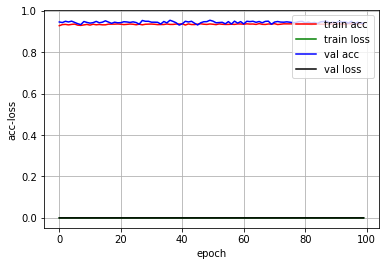

In [9]:
image_train, label_train = input_data()  
image_train = image_train.astype('float32')
label_train = label_train.astype('float32')
image_train /= 255.0
# label_train /= 128.0
print("image_train:", str(image_train.shape))
print("label_train:", str(label_train.shape))
K.clear_session()
dsize = 96
model = cnn_facealignment(size=(dsize,dsize,3))
# model = load_model("model/face_alignment.h5")
#model =  multi_gpu_model(model, use_gpu_num)
model.summary()#打印模型概况
model.compile(optimizer = "adam", loss = 'mse',  metrics = ["accuracy"])
history = LossHistory()
print("image_train:", str(image_train.shape))
print("label_train:", str(label_train.shape))
lr = LearningRateScheduler(step_decay)
checkpoint = ModelCheckpoint(filepath='model/face_alignment.h5',monitor='val_loss',mode='auto' ,save_best_only='True')
callback_lists=[checkpoint,history, lr]
model.fit(image_train, label_train,epochs=100,verbose=1,validation_split=0.2, shuffle=True,batch_size=32,callbacks=callback_lists)
model.save("model/face_alignment.h5")
print("Model save done!")
history.loss_plot('epoch')

In [10]:
from keras.models import load_model
import tensorflow as tf
import os 
import os.path as osp
from keras import backend as K

#路径参数
input_path = 'input path'
weight_file = 'face_alignment.h5'
weight_file_path = osp.join(input_path,weight_file)
output_graph_name = weight_file[:-3] + '.pb'
#转换函数
def h5_to_pb(h5_model,output_dir,model_name,out_prefix = "output_",log_tensorboard = True):
    if osp.exists(output_dir) == False:
        os.mkdir(output_dir)
    out_nodes = []
    for i in range(len(h5_model.outputs)):
        out_nodes.append(out_prefix + str(i + 1))
        tf.identity(h5_model.output[i],out_prefix + str(i + 1))
    sess = K.get_session()
    from tensorflow.python.framework import graph_util,graph_io
    init_graph = sess.graph.as_graph_def()
    main_graph = graph_util.convert_variables_to_constants(sess,init_graph,out_nodes)
    graph_io.write_graph(main_graph,output_dir,name = model_name,as_text = False)
    if log_tensorboard:
        from tensorflow.python.tools import import_pb_to_tensorboard
        import_pb_to_tensorboard.import_to_tensorboard(osp.join(output_dir,model_name),output_dir)
#输出路径
output_dir = osp.join(os.getcwd(),"trans_model")
#加载模型
# h5_model = load_model(weight_file_path)
h5_to_pb(model,output_dir = output_dir,model_name = output_graph_name)
print('model saved')

INFO:tensorflow:Froze 26 variables.
INFO:tensorflow:Converted 26 variables to const ops.
Model Imported. Visualize by running: tensorboard --logdir=/home/shuofeng/AIProject/FaceAlignment/trans_model
model saved
